# Projection Fourier Transform Difference Test

In order to better isolate features for the neural network to read through, the initial data must be engineered in such a way that the correct patterns are analyzed. For image alignment, normally the goal is to optimize the output by looking at the differences in the data as opposed to the actual data itself.

In this notebook, we are creating a stack of fourier transforms of projection differences to be fed into the neural network.

In [10]:
# Import essential packages
import os
import math
import numpy as np
import matplotlib.pyplot as plt

# Import tomography and imaging packages
import tomopy
from skimage.transform import rotate, AffineTransform
from skimage import transform as tf
from scipy.fft import fft2, fftshift

# Import neural net packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.profiler
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torchinfo import summary

In [2]:
# Checking to ensure environment and cuda are correct
print("Working Environment: {}".format(os.environ['CONDA_DEFAULT_ENV']))
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print("Cuda Version: {}".format(torch.version.cuda))
print("Cuda Availability: {}".format(torch.cuda.is_available()))

Working Environment: pytorch
Cuda Version: 11.8
Cuda Availability: True


In [3]:
# Loading data, 25 entries of 128 resolution shepp3ds
res = 128
entries = 250
data = []

for i in range(entries):
    data.append(np.load('./shepp{}-{}/shepp{}-{}_{}.npy'.format(res, entries, res, entries, i), 
                        allow_pickle = True))
    
data = np.asarray(data)

(250, 2)
(2,)
(1, 1, 180, 128, 184)
(1, 360)
(180, 128, 184)


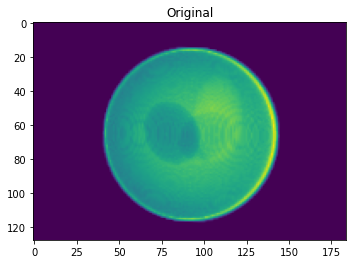

In [4]:
# Checking shape of original data
print(data.shape)
print(data[0].shape)
print(data[0][0].shape)
print(data[0][1].shape)

# Getting rid of dimensions added for neural networks in order to plot
test_proj = np.squeeze(data[0][0])
print(test_proj.shape)

# Plot example projection
plt.imshow(test_proj[45, :, :])
plt.title('Original')
plt.show()

In [11]:
def data_fourier_difference(data, entries):

    data_diff = np.zeros((data.shape), dtype = object)
    projections = []

    for i in range (entries):
        projections.append(np.squeeze(data[:, 0][i]))

    projections = np.asarray(projections)

    differences = np.zeros((entries, projections[0].shape[0] - 1), dtype = object)

    for i in range (entries):

        for j in range (projections[0].shape[0] - 1):

            differences[i, j] = fftshift(fft2((projections[i][j + 1] - projections[i][j])))

    for i in range (data_diff.shape[0]):

        data_diff[i][0] = np.zeros((differences.shape[1], differences[0, 0].shape[0], differences[0,0].shape[1]))
        data_diff[i][1] = data[i][1]

        for j in range (projections[0].shape[0] - 1):

            data_diff[i][0][j] = differences[i, j]

        data_diff[i][0] = np.expand_dims(data_diff[i][0], axis = 0)
        data_diff[i][0] = np.expand_dims(data_diff[i][0], axis = 0)

    return data_diff

data_diff = data_fourier_difference(data.copy(), entries)

print(data_diff.shape)
print(data_diff[0].shape)
print(data_diff[0][0].shape)
print(data_diff[0][1].shape)

/tmp/ipykernel_9065/1101812413.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  data_diff[i][0][j] = differences[i, j]


(250, 2)
(2,)
(1, 1, 179, 128, 184)
(1, 360)


In [12]:
print(data_diff[0][0][0,0].shape)

(179, 128, 184)


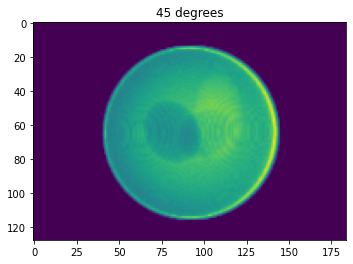

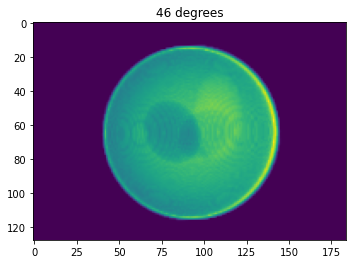

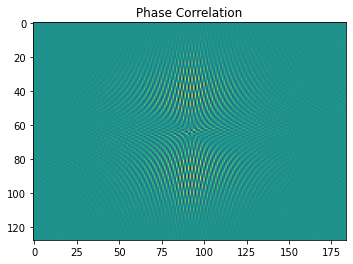

In [16]:
# Plot 45 degrees projection
plt.imshow(data[0][0][0, 0, 46, :, :])
plt.title('45 degrees')
plt.show()

# Plot 46 degrees projection
plt.imshow(data[0][0][0, 0, 46, :, :])
plt.title('46 degrees')
plt.show()

# Plot fourier difference
plt.imshow(data_diff[0][0][0, 0, 45, :, :])
plt.title('Phase Correlation')
plt.show()